# Installation

In [1]:
# Install necessary Python packages for data analysis, visualization, and machine learning
!pip install pyspark -q # Install PySpark for distributed data processing
!pip install numpy # Install NumPy for numerical computations
!pip install pandas # Install Pandas for data manipulation and analysis
!pip install seaborn # Install Seaborn for statistical data visualization
!pip install squarify # Install Squarify for creating treemaps
!pip install scikit-learn # Install scikit-learn for machine learning algorithms

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 1.3 MB/s eta 0:00:00m eta 0:00:010:00:01
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 1.4 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 KB 938.9 kB/s eta 0:00:00m eta 0:00:010:01:01
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 KB 1.1 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 1.6 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.7/300.7 KB 2.0 MB/s eta 0:00:002.4 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 1.9 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.9 MB/s

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import squarify

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.ml import Pipeline
from pyspark.sql import SQLContext
from pyspark.sql.functions import mean, col, split, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes


from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve, auc
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Connect to Spark

In [3]:
# Create a Spark session with a specified application name for Brain Stroke Prediction
spark = SparkSession.builder.appName('Brain Stroke Prediction').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/01 23:25:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/09/01 23:25:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/09/01 23:25:36 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [4]:
# Get the SparkContext from the existing Spark session
sc = spark.sparkContext.getOrCreate()

# Examine data

In [5]:
# Read a CSV file into a Spark DataFrame for brain stroke prediction data
path = 'brain_stroke.csv'
df = spark.read.csv(path, header='True', inferSchema='True')
df.show(10)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.12|24.0|   never smoked|     1|
|  Male|81.0|           0|            0|         Yes|      Private|         Urban|           186.

In [6]:
# Convert a limited subset of Spark DataFrame to a Pandas DataFrame for visualization or analysis
df.limit(10).toPandas()

gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1    Male  80.0             0              1          Yes        Private   
2  Female  49.0             0              0          Yes        Private   
3  Female  79.0             1              0          Yes  Self-employed   
4    Male  81.0             0              0          Yes        Private   
5    Male  74.0             1              1          Yes        Private   
6  Female  69.0             0              0           No        Private   
7  Female  78.0             0              0          Yes        Private   
8  Female  81.0             1              0          Yes        Private   
9  Female  61.0             0              1          Yes       Govt_job   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             105.92  32.5     never smoked       1  
2          Urban             171.23  34.4           smokes       1  
3          Rural             174.12  24.0     never smoked       1  
4          Urban             186.21  29.0  formerly smoked       1  
5          Rural              70.09  27.4     never smoked       1  
6          Urban              94.39  22.8     never smoked       1  
7          Urban              58.57  24.2          Unknown       1  
8          Rural              80.43  29.7     never smoked       1  
9          Rural             120.46  36.8           smokes       1

In [7]:
# Display the schema of the Spark DataFrame to understand its structure
df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [8]:
# Count the number of missing values (null or NaN) in each column of the Spark DataFrame
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



## Convert dataframe to Pandas to enable Seaborn and Matplotlib

In [9]:
# Convert the Spark DataFrame to a Pandas DataFrame and perform value mapping for specific columns
df_pd = df.toPandas()

# Mapping values in the 'stroke' column to more readable labels
df_pd.loc[(df_pd.stroke == 1), 'stroke']='Stroke'
df_pd.loc[(df_pd.stroke == 0), 'stroke']='No stroke'

# Mapping values in the 'heart_disease' column to more readable labels
df_pd.loc[(df_pd.heart_disease == 1), 'heart_disease']='Heart disease'
df_pd.loc[(df_pd.heart_disease == 0), 'heart_disease']='No heart disease'

# Mapping values in the 'hypertension' column to more readable labels
df_pd.loc[(df_pd.hypertension == 1), 'hypertension']='Hypertension'
df_pd.loc[(df_pd.hypertension == 0), 'hypertension']='No hypertension'

# Data Visualization

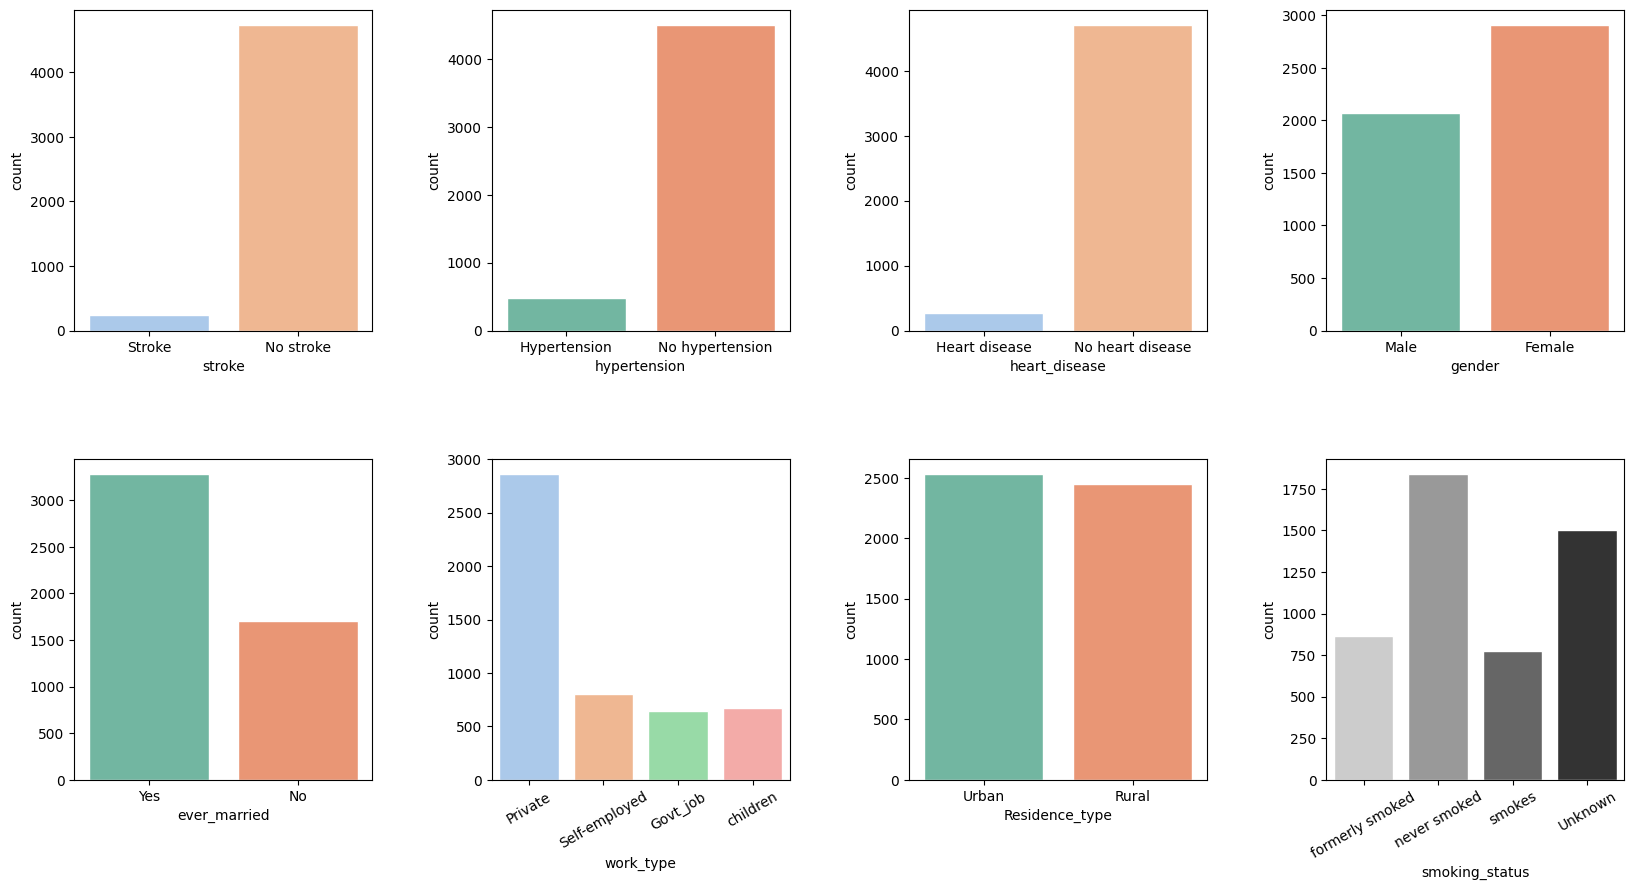

In [10]:
# Create subplots for visualizing categorical features of the dataset
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)# Adjust spacing between subplots
sns.set_theme()# Set Seaborn theme for consistent styling

# Countplot for 'stroke' column
sns.countplot(data=df_pd, x='stroke', ax=axes[0, 0], palette='pastel')

# Countplot for 'heart_disease' column
sns.countplot(data=df_pd, x='hypertension', order=['Hypertension', 'No hypertension'], ax=axes[0, 1], palette='Set2')

# Countplot for 'heart_disease' column
sns.countplot(data=df_pd, x='heart_disease', ax=axes[0, 2], palette='pastel')

# Countplot for 'gender' column
sns.countplot(data=df_pd, x='gender', ax=axes[0, 3], palette='Set2')

# Countplot for 'ever_married' column
sns.countplot(data=df_pd, x='ever_married', ax=axes[1, 0], palette='Set2')

# Countplot for 'work_type' column
sns.countplot(data=df_pd, x='work_type', ax=axes[1, 1], palette='pastel')
axes[1, 1].tick_params(axis='x', rotation=30)# Rotate x-axis labels for better readability

# Countplot for 'Residence_type' column
sns.countplot(data=df_pd, x='Residence_type', ax=axes[1, 2], palette='Set2')

# Countplot for 'smoking_status' column
sns.countplot(data=df_pd, x='smoking_status', ax=axes[1, 3], palette='binary')
axes[1, 3].tick_params(axis='x', rotation=30)# Countplot for 'Residence_type' column

# Display the subplots
plt.show()


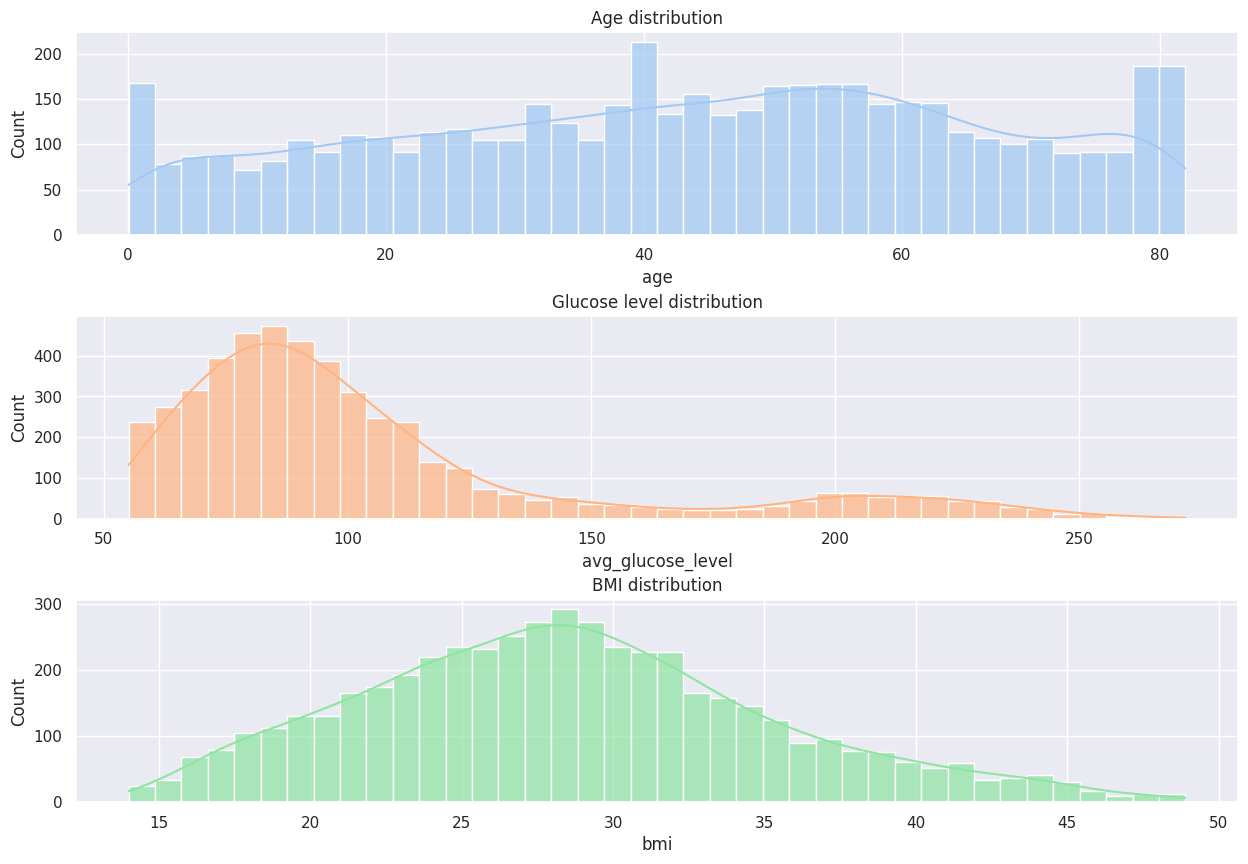

In [11]:
# Create subplots for visualizing numerical feature distributions
fig, axes = plt.subplots(3, 1, figsize=(15, 10))# Create subplots for visualizing numerical feature distributions
plt.subplots_adjust(hspace=0.4)
sns.set_theme()# Set Seaborn theme for consistent styling

# Define color palette
palette = sns.color_palette("pastel")

# Plot age distribution
axes[0].set_title('Age distribution')
sns.histplot(df_pd['age'], bins=40 , kde=True, alpha=0.7, ax=axes[0], color=palette[0])

# Plot glucose level distribution
axes[1].set_title('Glucose level distribution')
sns.histplot(df_pd['avg_glucose_level'], bins=40, kde=True, alpha=0.7, ax=axes[1], color=palette[1])

# Plot BMI distribution
axes[2].set_title('BMI distribution')
sns.histplot(df_pd['bmi'], bins=40, kde=True, alpha=0.7, ax=axes[2], color=palette[2])

 # Display the subplots
plt.show()

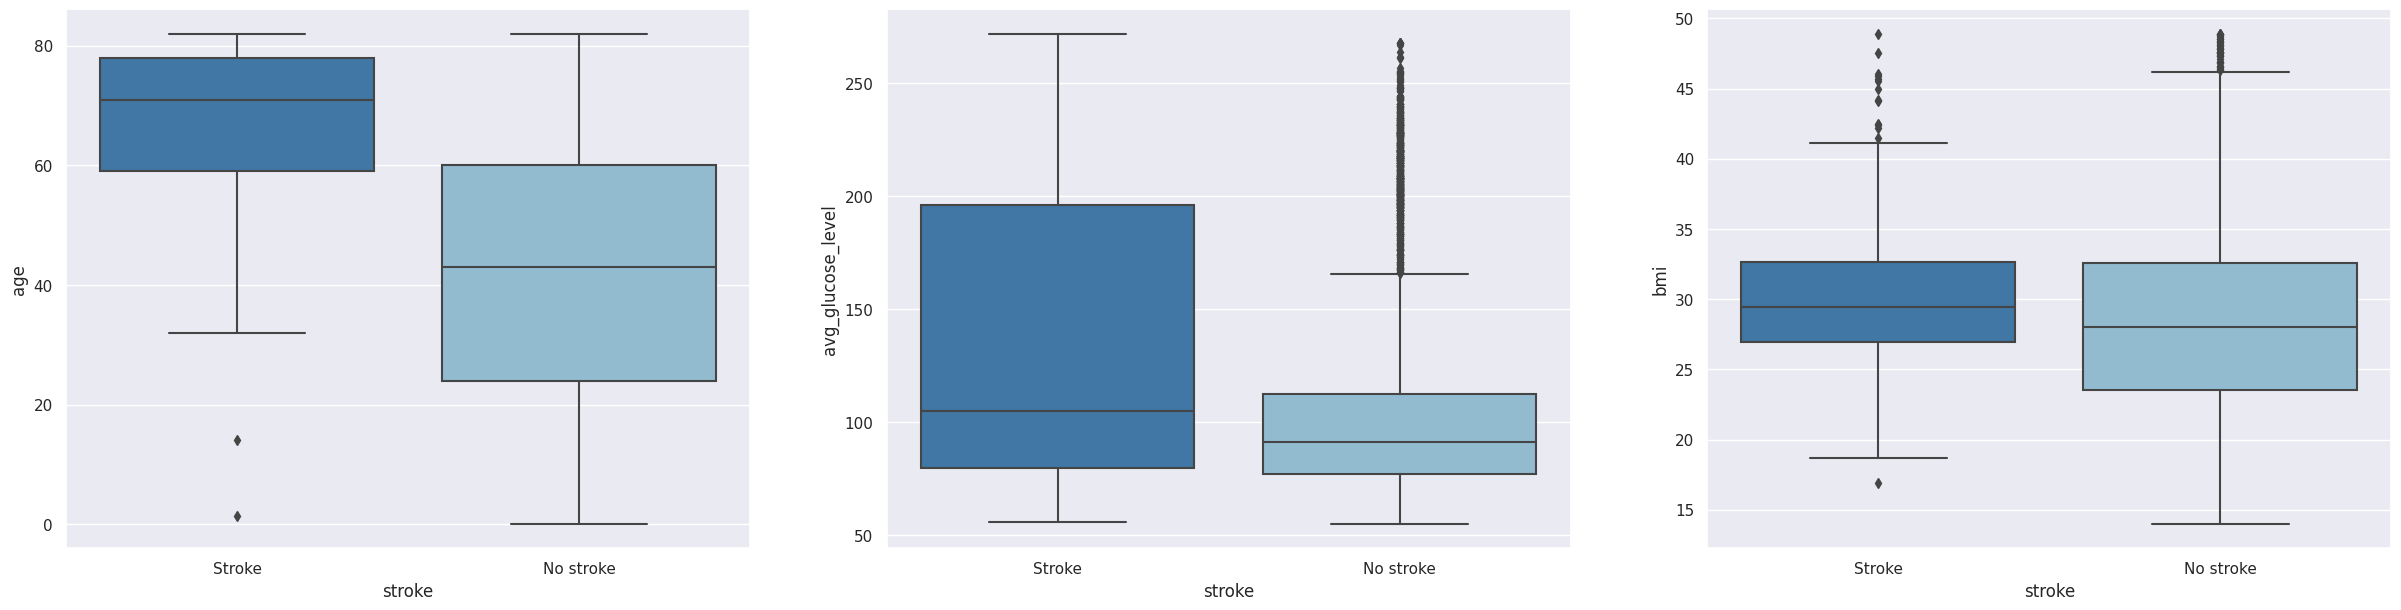

In [12]:
# Create subplots for visualizing box plots of numerical features grouped by stroke status
fig, axes = plt.subplots(1, 3, figsize=(30, 7))

# Define color palette
palette = sns.color_palette("RdBu_r")

# Box plot for 'age' grouped by 'stroke' status
sns.boxplot(data=df_pd, x='stroke', y='age', ax=axes[0], palette=palette)

# Box plot for 'avg_glucose_level' grouped by 'stroke' status
sns.boxplot(data=df_pd, x='stroke', y='avg_glucose_level', ax=axes[1], palette=palette)

# Box plot for 'bmi' grouped by 'stroke' status
sns.boxplot(data=df_pd, x='stroke', y='bmi', ax=axes[2], palette=palette)

# Display the subplots
plt.show()

<Axes: title={'center': 'Gender and no strokes'}, xlabel='gender', ylabel='count'>

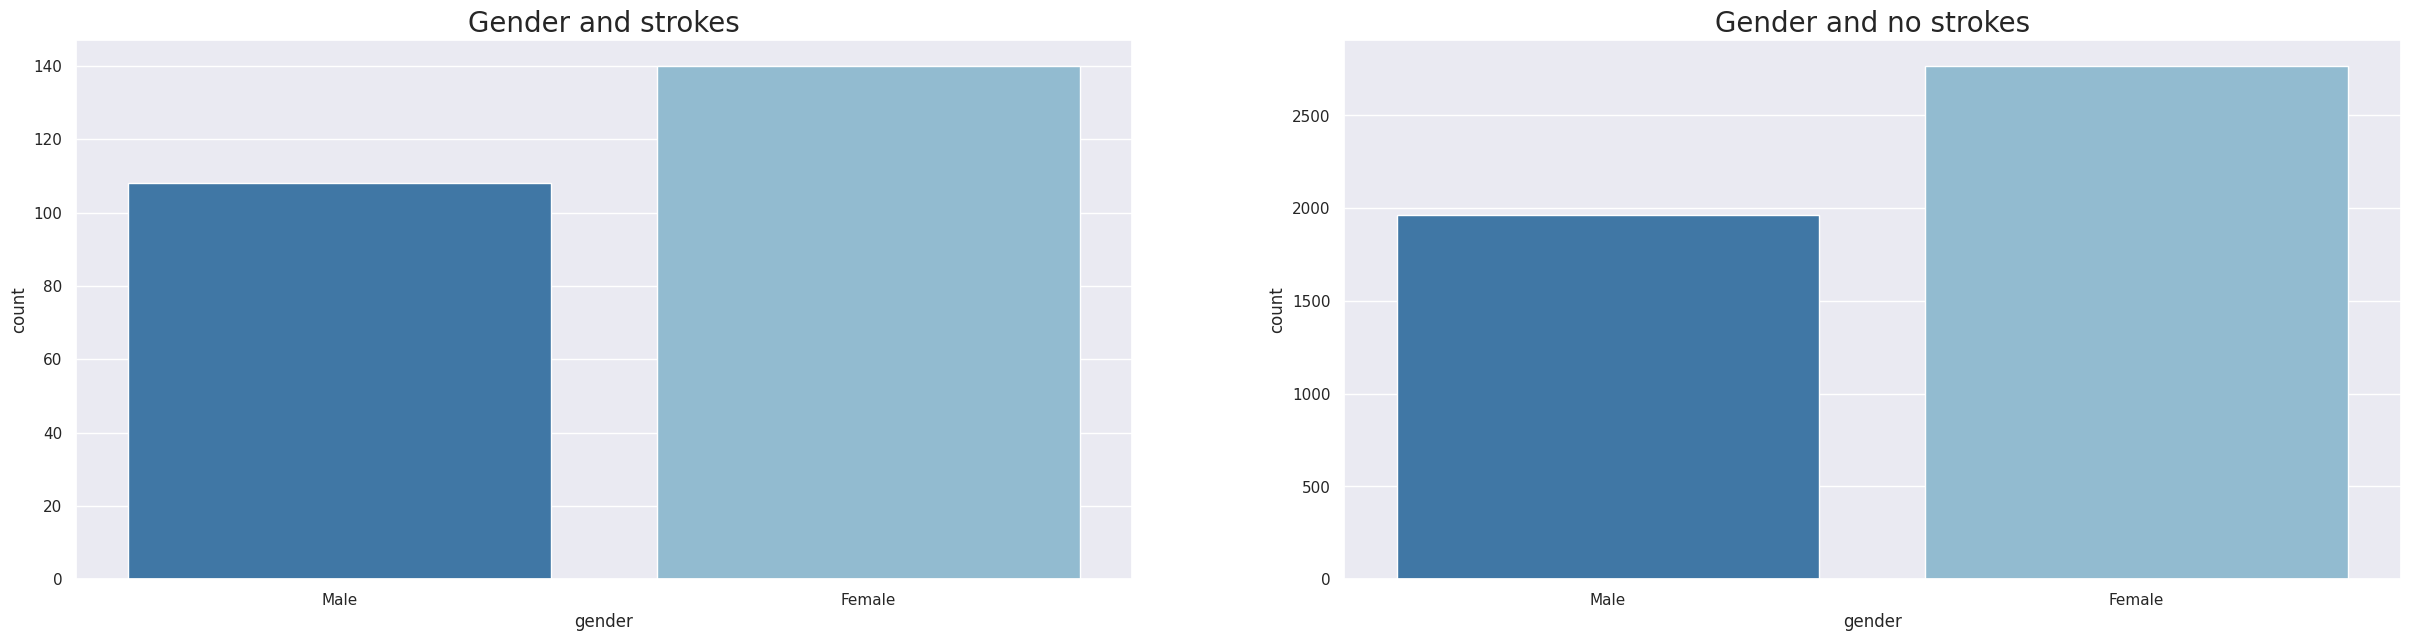

In [13]:
# Create subplots for comparing gender distribution among stroke and no-stroke cases
fig, axes = plt.subplots(1, 2, figsize=(30,7))

# Define color palette
palette = sns.color_palette("RdBu_r")

# Plot gender distribution among stroke cases
axes[0].set_title('Gender and strokes', fontsize=20)
sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'Stroke'], x='gender', ax=axes[0], palette=palette)

# Plot gender distribution among no-stroke cases
axes[1].set_title('Gender and no strokes', fontsize=20)
sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'No stroke'], x='gender', ax=axes[1], palette=palette)

<Axes: title={'center': 'Hypertension and no strokes'}, xlabel='hypertension', ylabel='count'>

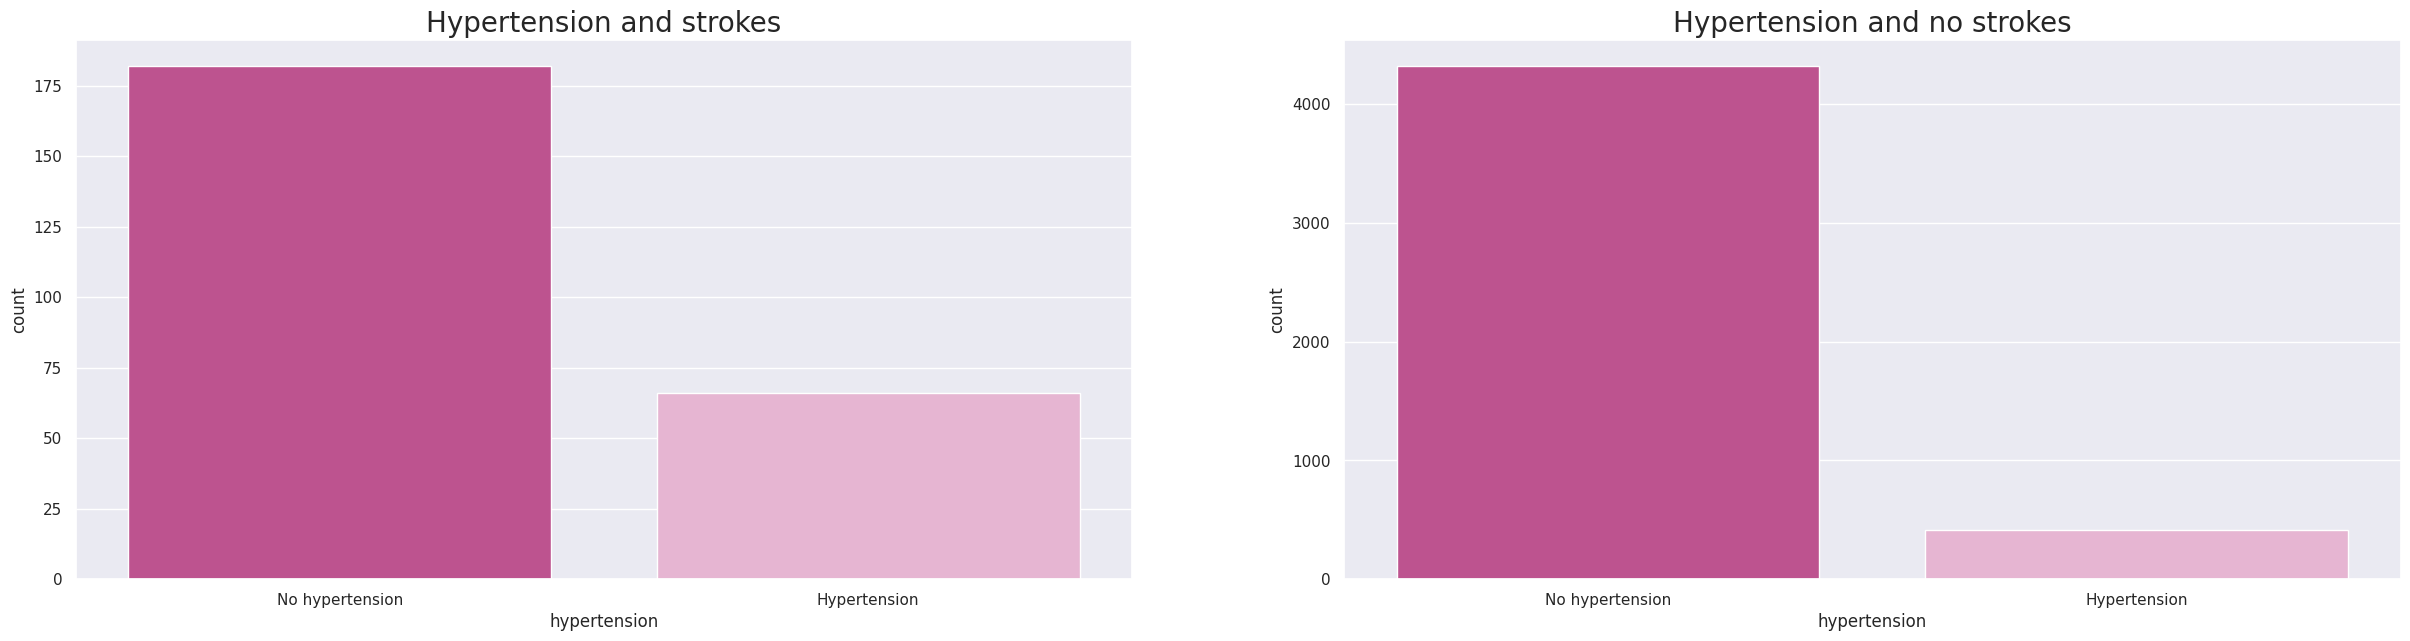

In [14]:
# Create subplots for comparing hypertension distribution among stroke and no-stroke cases
fig, axes = plt.subplots(1, 2, figsize=(30,7))

# Define color palette
palette = sns.color_palette("PiYG")

# Plot hypertension distribution among stroke cases
axes[0].set_title('Hypertension and strokes', fontsize=20)
sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'Stroke'], x='hypertension', 
              ax=axes[0], palette=palette)

# Plot hypertension distribution among no-stroke cases
axes[1].set_title('Hypertension and no strokes', fontsize=20)
sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'No stroke'], x='hypertension', 
              ax=axes[1], palette=palette)

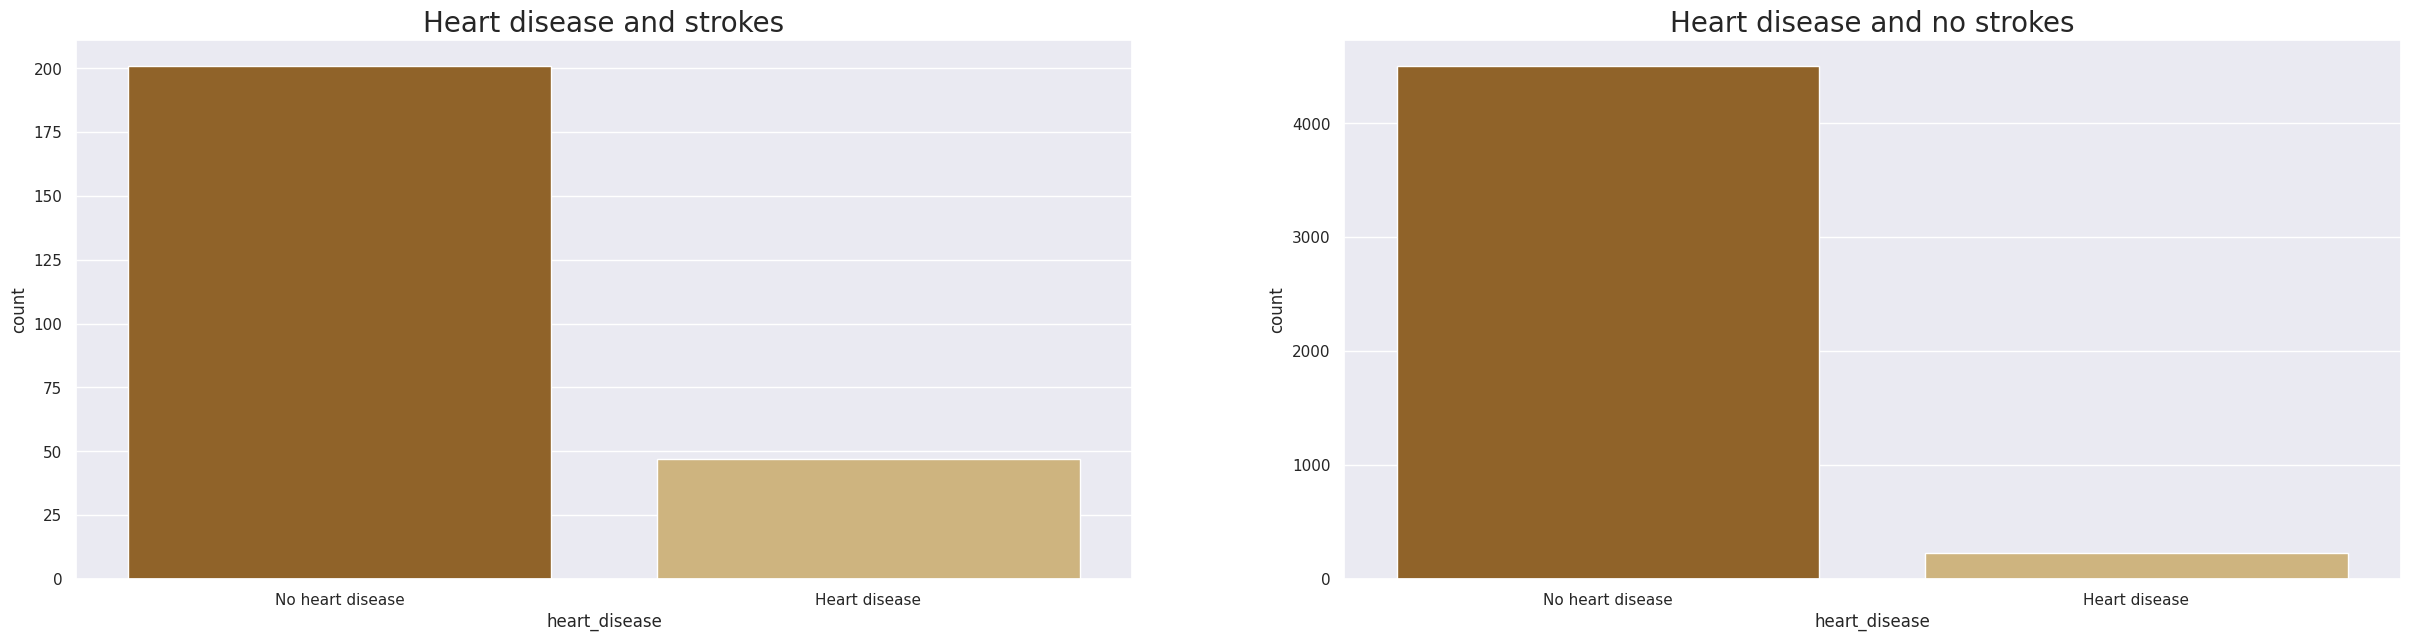

In [15]:
# Create subplots for comparing heart disease distribution among stroke and no-stroke cases
fig, axes = plt.subplots(1, 2, figsize=(30,7))

# Define color palette
palette = sns.color_palette("BrBG")

# Plot heart disease distribution among stroke cases
axes[0].set_title('Heart disease and strokes', fontsize=20)
ax0 = sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'Stroke'], x='heart_disease', 
                    order=['No heart disease', 'Heart disease'],ax=axes[0], palette=palette)

# Plot heart disease distribution among no-stroke cases
axes[1].set_title('Heart disease and no strokes', fontsize=20)
ax1 = sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'No stroke'], x='heart_disease', 
                    ax=axes[1], palette=palette)

<Axes: title={'center': 'Unmarried and no strokes'}, xlabel='ever_married', ylabel='count'>

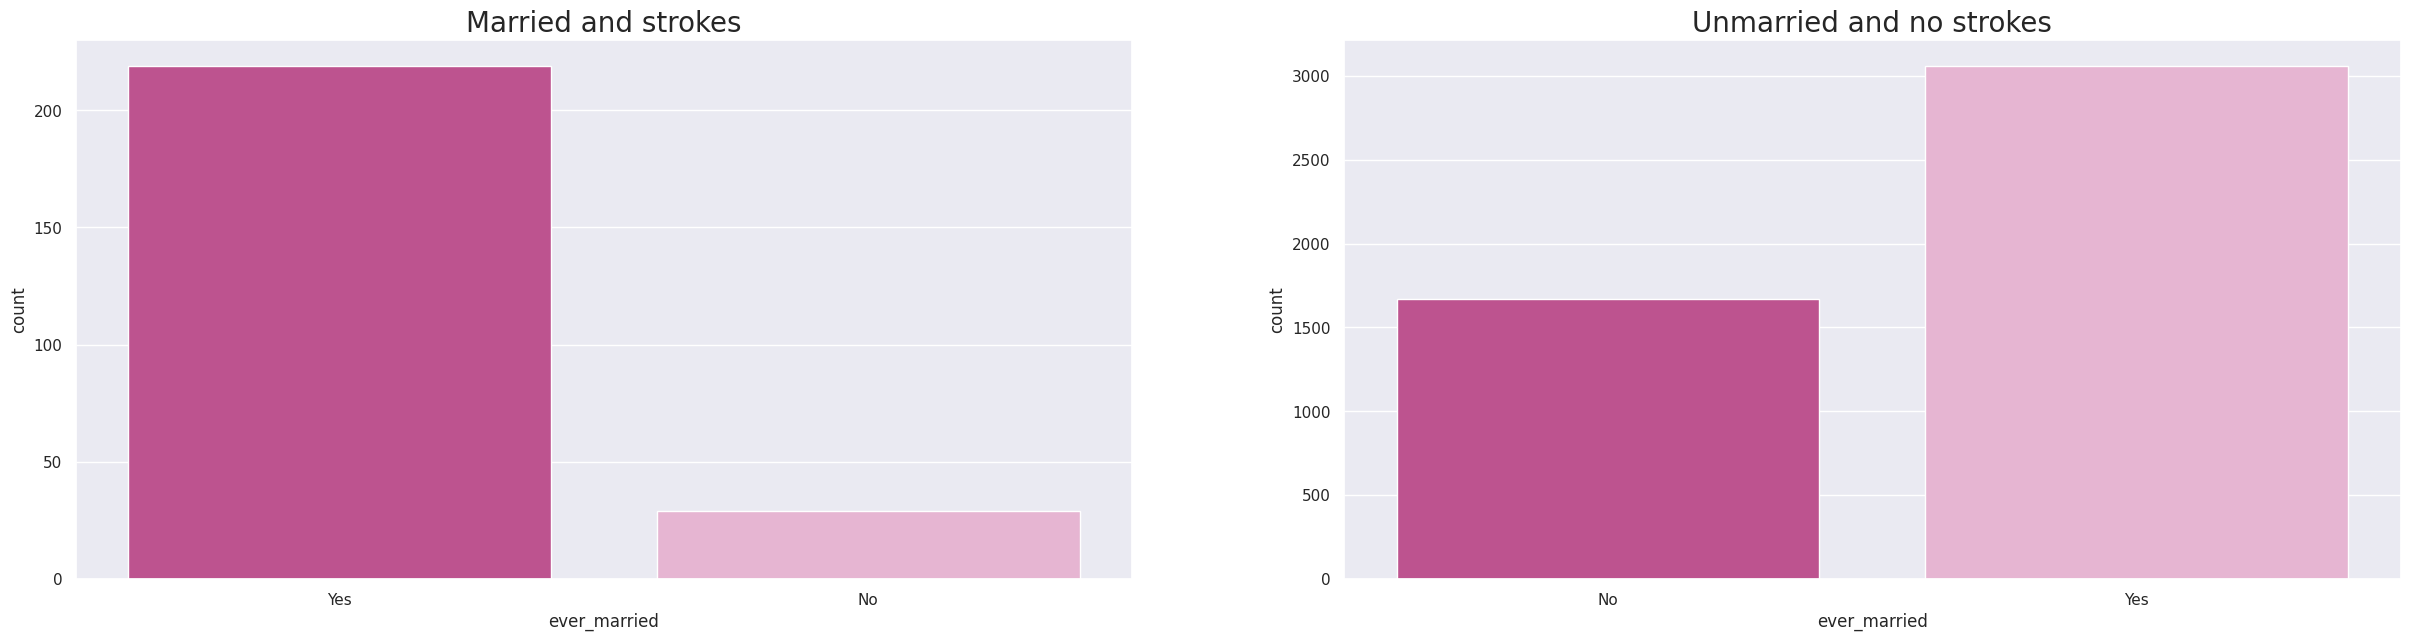

In [16]:
# Create subplots for comparing marital status distribution among stroke and no-stroke cases
fig, axes = plt.subplots(1, 2, figsize=(30,7))

# Define color palette
palette = sns.color_palette("PiYG")

# Plot marital status distribution among stroke cases
axes[0].set_title('Married and strokes', fontsize=20)
sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'Stroke'], x='ever_married', 
              ax=axes[0], palette=palette)

# Plot marital status distribution among no-stroke cases
axes[1].set_title('Unmarried and no strokes', fontsize=20)
sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'No stroke'], x='ever_married',
              ax=axes[1], palette=palette)

<Axes: title={'center': 'SmokingStatus and no strokes'}, xlabel='smoking_status', ylabel='count'>

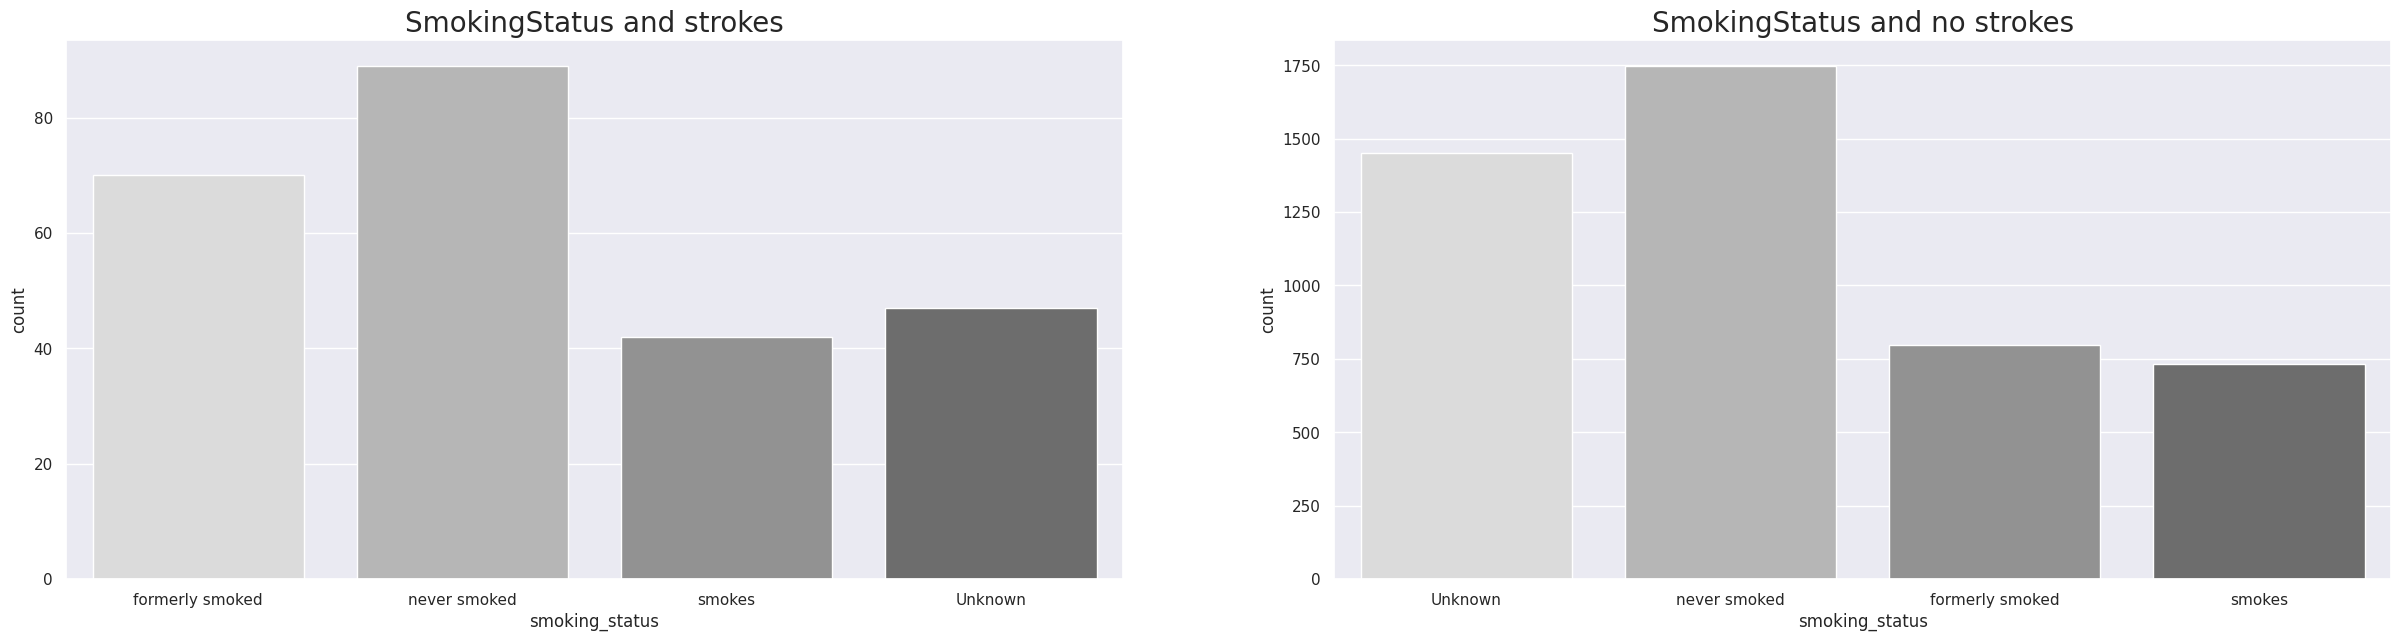

In [17]:
# Create subplots for comparing smoking status distribution among stroke and no-stroke cases
fig, axes = plt.subplots(1, 2, figsize=(30,7))

# Define color palette
palette = sns.color_palette("binary")

# Plot smoking status distribution among stroke cases
axes[0].set_title('SmokingStatus and strokes', fontsize=20)
sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'Stroke'], x='smoking_status', 
              ax=axes[0], palette=palette)

# Plot smoking status distribution among no-stroke cases
axes[1].set_title('SmokingStatus and no strokes', fontsize=20)
sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'No stroke'], x='smoking_status',
              ax=axes[1], palette=palette)

<Axes: title={'center': 'Residence Type and no strokes'}, xlabel='Residence_type', ylabel='count'>

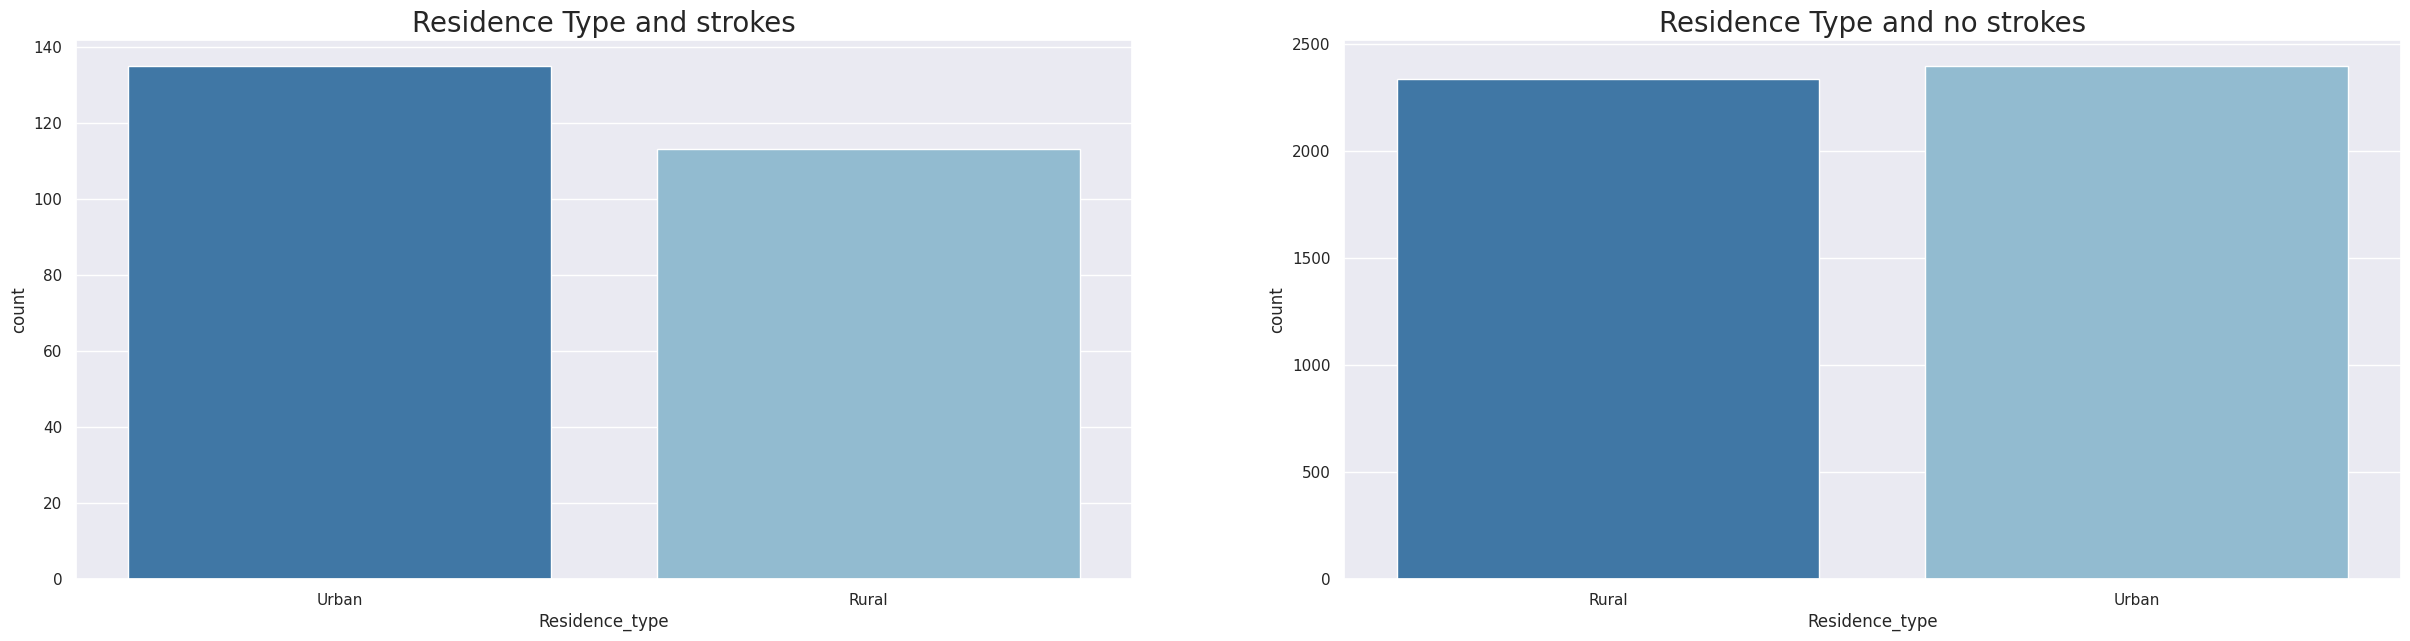

In [18]:
# Create subplots for comparing residence type distribution among stroke and no-stroke cases
fig, axes = plt.subplots(1, 2, figsize=(30,7))

# Define color palette
palette = sns.color_palette("RdBu_r")

# Plot residence type distribution among stroke cases
axes[0].set_title('Residence Type and strokes', fontsize=20)
sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'Stroke'], x='Residence_type', 
              ax=axes[0], palette=palette)

# Plot residence type distribution among no-stroke cases
axes[1].set_title('Residence Type and no strokes', fontsize=20)
sns.countplot(data=df_pd.loc[df_pd['stroke'] == 'No stroke'], x='Residence_type',ax=axes[1], palette=palette)

In [20]:
# List of categorical columns for further analysis
categorical = ('gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status')

# Convert string data to numerical

In [23]:
# String Indexing categorical columns to convert them into numerical vectors
indexer = StringIndexer(inputCol='gender', outputCol='gender_vec')
df_indexed = indexer.fit(df).transform(df)

indexer2 = StringIndexer(inputCol='ever_married', outputCol='married_vec')
df_indexed2 = indexer2.fit(df_indexed).transform(df_indexed)

indexer3 = StringIndexer(inputCol='work_type', outputCol='work_vec')
df_indexed3 = indexer3.fit(df_indexed2).transform(df_indexed2)

indexer4 = StringIndexer(inputCol='Residence_type', outputCol='residence_vec')
df_indexed4 = indexer4.fit(df_indexed3).transform(df_indexed3)

indexer5 = StringIndexer(inputCol='smoking_status', outputCol='smoking_vec')
df_indexed5 = indexer5.fit(df_indexed4).transform(df_indexed4)

# String Indexing categorical columns to convert them into numerical vectors
df = df_indexed5.drop(*categorical)
df.show(3)

+----+------------+-------------+-----------------+----+------+---------+----------+-----------+--------+-------------+-----------+
| age|hypertension|heart_disease|avg_glucose_level| bmi|stroke|high_risk|gender_vec|married_vec|work_vec|residence_vec|smoking_vec|
+----+------------+-------------+-----------------+----+------+---------+----------+-----------+--------+-------------+-----------+
|67.0|           0|            1|           228.69|36.6|     1|        0|       1.0|        0.0|     0.0|          0.0|        2.0|
|80.0|           0|            1|           105.92|32.5|     1|        1|       1.0|        0.0|     0.0|          1.0|        0.0|
|49.0|           0|            0|           171.23|34.4|     1|        0|       0.0|        0.0|     0.0|          0.0|        3.0|
+----+------------+-------------+-----------------+----+------+---------+----------+-----------+--------+-------------+-----------+
only showing top 3 rows



In [24]:
# Create a vector assembler to combine features into a single vector column
feature = VectorAssembler(inputCols = df.drop('stroke').columns, outputCol='features')
feature_vector = feature.transform(df)
# Display the DataFrame with the added 'features' column
feature_vector.show(3)

+----+------------+-------------+-----------------+----+------+---------+----------+-----------+--------+-------------+-----------+--------------------+
| age|hypertension|heart_disease|avg_glucose_level| bmi|stroke|high_risk|gender_vec|married_vec|work_vec|residence_vec|smoking_vec|            features|
+----+------------+-------------+-----------------+----+------+---------+----------+-----------+--------+-------------+-----------+--------------------+
|67.0|           0|            1|           228.69|36.6|     1|        0|       1.0|        0.0|     0.0|          0.0|        2.0|(11,[0,2,3,4,6,10...|
|80.0|           0|            1|           105.92|32.5|     1|        1|       1.0|        0.0|     0.0|          1.0|        0.0|[80.0,0.0,1.0,105...|
|49.0|           0|            0|           171.23|34.4|     1|        0|       0.0|        0.0|     0.0|          0.0|        3.0|(11,[0,3,4,10],[4...|
+----+------------+-------------+-----------------+----+------+---------+---------

In [25]:
# Select relevant columns for the machine learning dataset
ml_df = feature_vector.select(['features', 'stroke'])
# Split the dataset into training and testing sets
# 80% of data is used for training and 20% for testing, with a fixed seed for reproducibility
train, test = ml_df.randomSplit([0.8, 0.2],seed=42)

# Logistic Regression

In [26]:

# Create a Logistic Regression classifier with the label column set to 'stroke'
lr = LogisticRegression(labelCol='stroke')

# Define a grid of hyperparameters for the parameter grid builder
paramGrid = ParamGridBuilder().addGrid(lr. regParam, (0.01, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25, 0.75))\
                              .build()

# Create a TrainValidationSplit for hyperparameter tuning
tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=MulticlassClassificationEvaluator(labelCol='stroke'),
                           trainRatio=0.8)

# Fit the TrainValidationSplit on the training data
lr_model = tvs.fit(train)


# Make predictions on the test data using the trained model
lr_model_pred = lr_model.transform(test)

In [27]:
# Select relevant columns for evaluation
results = lr_model_pred.select(['probability', 'stroke'])

# Collect the results and create a list of tuples for score and labels
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]

# Parallelize the list of tuples for further metric computation
scoreAndLabels = sc.parallelize(results_list)

# Compute classification metrics
metrics = metric(scoreAndLabels)

# Evaluate the Logistic Regression model's accuracy, precision, and ROC score
lr_acc = round(MulticlassClassificationEvaluator(labelCol='stroke', metricName='accuracy').evaluate(lr_model_pred), 4)
lr_prec = round(MulticlassClassificationEvaluator(labelCol='stroke', metricName='weightedPrecision').evaluate(lr_model_pred), 4)
lr_roc = round(metrics.areaUnderROC, 4)

# Create a dictionary to store the evaluation metrics
lr_dict = {'Accuracy': lr_acc, 'Precision': lr_prec, 'ROC Score': lr_roc}

# Display the evaluation metrics dictionary
print(lr_dict)

/home/asha1/.local/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


{'Accuracy': 0.9464, 'Precision': 0.8956, 'ROC Score': 0.8281}


# Decision Tree

In [28]:
# Decision Tree classifier setup
dt = DecisionTreeClassifier(labelCol='stroke')

# Define a grid of hyperparameters for hyperparameter tuning
paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, [5, 10])\
                              .addGrid(dt.maxBins, [32, 64])\
                              .build()
# Create a TrainValidationSplit for hyperparameter tuning
tvs = TrainValidationSplit(estimator=dt,
                           estimatorParamMaps=paramGrid,
                           evaluator=MulticlassClassificationEvaluator(labelCol='stroke'),
                           trainRatio=0.8)

# Fit the TrainValidationSplit on the training data to tune hyperparameters
dt_model = tvs.fit(train)

# Make predictions on the test data using the trained Decision Tree model
dt_model_pred = dt_model.transform(test)



In [29]:
# Select relevant columns for evaluation
results = dt_model_pred.select(['probability', 'stroke'])
# Collect the results and create a list of tuples for score and labels

results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0 - float(i[1])) for i in results_collect]

# Parallelize the list of tuples for further metric computation
scoreAndLabels = sc.parallelize(results_list)

# Assuming you have a metric function defined
# Compute classification metrics using the defined metric function
metrics = metric(scoreAndLabels)

# Evaluate the Decision Tree model's accuracy, precision, and ROC score
dt_acc = round(MulticlassClassificationEvaluator(labelCol='stroke', metricName='accuracy').evaluate(dt_model_pred), 4)
dt_prec = round(MulticlassClassificationEvaluator(labelCol='stroke', metricName='weightedPrecision').evaluate(dt_model_pred), 4)
dt_roc = round(metrics.areaUnderROC, 4)

# Create a dictionary to store the evaluation metrics
dt_dict = {'Accuracy': dt_acc, 'Precision': dt_prec, 'ROC Score': dt_roc}

# Display the evaluation metrics dictionary
print(dt_dict)

{'Accuracy': 0.9422, 'Precision': 0.9052, 'ROC Score': 0.7866}


# Random Forest

In [30]:
# Random Forest classifier setup
rf = RandomForestClassifier(labelCol='stroke')

# Define a grid of hyperparameters for hyperparameter tuning
paramGrid = ParamGridBuilder().addGrid(rf.maxDepth, [5, 10, 20])\
                              .addGrid(rf.maxBins, [20, 32, 50])\
                              .addGrid(rf.numTrees, [20, 40, 60])\
                              .addGrid(rf.impurity, ['gini', 'entropy'])\
                              .addGrid(rf.minInstancesPerNode, [1, 5, 10])\
                              .build()

# Create a TrainValidationSplit for hyperparameter tuning
tvs = TrainValidationSplit(estimator=rf,
                           estimatorParamMaps=paramGrid,
                           evaluator=MulticlassClassificationEvaluator(labelCol='stroke'),
                           trainRatio=0.8)

# Fit the TrainValidationSplit on the training data to tune hyperparameters
rf_model = tvs.fit(train)

# Make predictions on the test data using the trained Random Forest model
rf_model_pred = rf_model.transform(test)

23/08/25 13:27:16 WARN DAGScheduler: Broadcasting large task binary with size 1167.5 KiB
23/08/25 13:27:16 WARN DAGScheduler: Broadcasting large task binary with size 1462.6 KiB
23/08/25 13:27:19 WARN DAGScheduler: Broadcasting large task binary with size 1160.4 KiB
23/08/25 13:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1243.5 KiB
23/08/25 13:27:27 WARN DAGScheduler: Broadcasting large task binary with size 1025.3 KiB
23/08/25 13:27:31 WARN DAGScheduler: Broadcasting large task binary with size 1263.6 KiB
23/08/25 13:27:32 WARN DAGScheduler: Broadcasting large task binary with size 1686.0 KiB
23/08/25 13:27:32 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/25 13:27:33 WARN DAGScheduler: Broadcasting large task binary with size 1368.7 KiB
23/08/25 13:27:34 WARN DAGScheduler: Broadcasting large task binary with size 1104.3 KiB
23/08/25 13:27:35 WARN DAGScheduler: Broadcasting large task binary with size 1376.2 KiB
23/08/25 13:27:35 WARN D

In [31]:
# Select relevant columns for evaluation
results = rf_model_pred.select(['probability', 'stroke'])


# Collect the results and create a list of tuples for score and labels
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]

# Parallelize the list of tuples for further metric computation
scoreAndLabels = sc.parallelize(results_list)

# Assuming you have a metric function defined
# Compute classification metrics using the defined metric function
metrics = metric(scoreAndLabels)

# Evaluate the Random Forest model's accuracy, precision, and ROC score
rf_acc = round(MulticlassClassificationEvaluator(labelCol='stroke', metricName='accuracy').evaluate(rf_model_pred), 4)
rf_prec = round(MulticlassClassificationEvaluator(labelCol='stroke', metricName='weightedPrecision').evaluate(rf_model_pred), 4)
rf_roc = round(metrics.areaUnderROC, 4)

# Create a dictionary to store the evaluation metrics
rf_dict = {'Accuracy': rf_acc, 'Precision': rf_prec, 'ROC Score': rf_roc}

# Display the evaluation metrics dictionary
print(rf_dict)

{'Accuracy': 0.9464, 'Precision': 0.8956, 'ROC Score': 0.8063}


# Naive Bayes

In [32]:
# Naive Bayes classifier setup
nb = NaiveBayes(labelCol='stroke')

# Define a grid of hyperparameters for hyperparameter tuning
paramGrid = ParamGridBuilder().addGrid(nb.smoothing, [0.1, 0.5, 1.0])\
                              .build()

# Create a TrainValidationSplit for hyperparameter tuning
tvs = TrainValidationSplit(estimator=nb,
                           estimatorParamMaps=paramGrid,
                           evaluator=MulticlassClassificationEvaluator(labelCol='stroke'),
                           trainRatio=0.8)
# Fit the TrainValidationSplit on the training data to tune hyperparameters
nb_model = tvs.fit(train)

# Make predictions on the test data using the trained Naive Bayes model
nb_model_pred = nb_model.transform(test)


In [33]:
# Select relevant columns for evaluation
results = nb_model_pred.select(['probability', 'stroke'])

# Collect the results and create a list of tuples for score and labels
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0 - float(i[1])) for i in results_collect]

# Parallelize the list of tuples for further metric computation
scoreAndLabels = sc.parallelize(results_list)

# Assuming you have a metric function defined
# Compute classification metrics using the defined metric function
metrics = metric(scoreAndLabels)

# Evaluate the Naive Bayes model's accuracy, precision, and ROC score
nb_acc = round(MulticlassClassificationEvaluator(labelCol='stroke', metricName='accuracy').evaluate(nb_model_pred), 4)
nb_prec = round(MulticlassClassificationEvaluator(labelCol='stroke', metricName='weightedPrecision').evaluate(nb_model_pred), 4)
nb_roc = round(metrics.areaUnderROC, 4)

# Create a dictionary to store the evaluation metrics
nb_dict = {'Accuracy': nb_acc, 'Precision': nb_prec, 'ROC Score': nb_roc}

# Display the evaluation metrics dictionary
print(nb_dict)

{'Accuracy': 0.8244, 'Precision': 0.9177, 'ROC Score': 0.7576}


# Model Comparision

In [34]:
# Create a list of dictionaries containing evaluation metrics for each model
dicts = [lr_dict, dt_dict ,rf_dict, nb_dict]

# Create a list of dictionaries containing evaluation metrics for each model
results = pd.DataFrame(dicts)

# Add a column 'Models' to the DataFrame
results['Models'] = ['Logistic Regression', 'Decision Tree','Random Forest','Naive Bayes']

# Set the 'Models' column as the index of the DataFrame
results.set_index(['Models'])

Accuracy  Precision  ROC Score
Models                                             
Logistic Regression    0.9464     0.8956     0.8281
Decision Tree          0.9422     0.9052     0.7866
Random Forest          0.9464     0.8956     0.8063
Naive Bayes            0.8244     0.9177     0.7576